Практическое задание №5. Атака с ограниченной памятью (PGD - Projected Gradient Descent)

1. Загрузка обученной модели и данных MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('../prz1/mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Точность: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9703 - loss: 0.0986
Точность: 0.9760000109672546


2. Реализация атаки PGD с использованием Foolbox

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


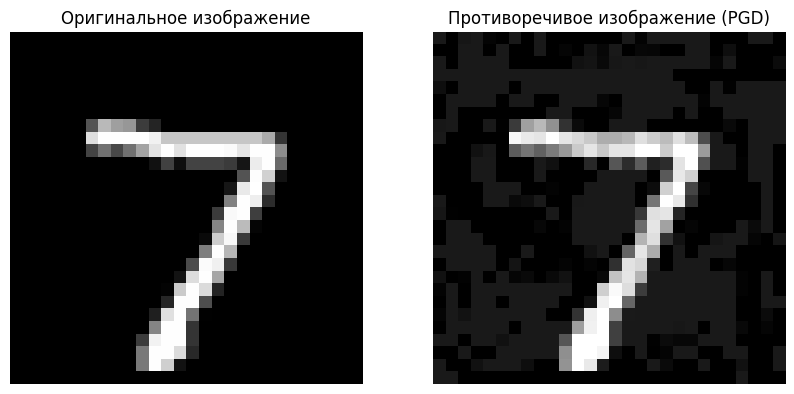

In [2]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Выполнение атаки
attack = fb.attacks.LinfPGD()
advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)

# Вывод оригинального и противоречивого изображения
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

3. Оценка модели на противоречивых примерах

In [3]:
adversarial_images = []

for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Точность (PGD): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.0416 - loss: 7.9188
Точность (PGD): 0.05889999866485596


Модель сильно уязвима к атакам типа PGD (Projected Gradient Descent). Первоначальная точность в 97% демонстрирует её эффективность на тестовых данных в обычных условиях. Однако снижение точности до 6% под воздействием PGD-атаки указывает на отсутствие устойчивости к небольшим целенаправленным изменениям входных данных, способным вводить модель в заблуждение.